In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pickle
import time
from tensorflow.keras.callbacks import TensorBoard
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import cv2
print("Ready")

2023-08-07 13:20:07.927692: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Ready


In [2]:
#
# read in data output from Part 1
#
pickle_in = open("tcg_segment_X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("tcg_segment_Y.pickle","rb")
Y = pickle.load(pickle_in)
number_channels=X.shape[3]
print('Input shape of the X features data: ',X.shape)
print('Input shape of the Y mask target data: ',Y.shape)
print('Number of input channel extracted from X is: ',number_channels)
#
# normalize the data before training the model
#
nsample = X.shape[0]
for i in range(nsample):
    for var in range(number_channels):    
        maxvalue = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('Normalization factor for sample and channel',i,var,', is: ',abs(maxvalue))
        X[i,:,:,var] = X[i,:,:,var]/abs(maxvalue)
        maxnew = X[i,:,:,var].flat[np.abs(X[i,:,:,var]).argmax()]
        #print('-->After normalization of sample and channel',i,var,', is: ',abs(maxnew))
        #input('Enter to continue...')
print("Finish normalization...")

Input shape of the X features data:  (292, 64, 128, 12)
Input shape of the Y mask target data:  (292, 64, 128, 1)
Number of input channel extracted from X is:  12
Finish normalization...


In [3]:
num_val_samples=25
train_input_imgs = X[:-num_val_samples]
train_targets = Y[:-num_val_samples]
val_input_imgs = X[-num_val_samples:]
val_targets = Y[-num_val_samples:]
img_size = (train_input_imgs.shape[1],train_input_imgs.shape[2],train_input_imgs.shape[3])
print(train_input_imgs.shape,train_targets.shape,img_size)

(267, 64, 128, 12) (267, 64, 128, 1) (64, 128, 12)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 128, 12)]     0         
                                                                 
 my_first_conv2d (Conv2D)    (None, 32, 64, 64)        6976      
                                                                 
 my_second_conv2d (Conv2D)   (None, 32, 64, 64)        36928     
                                                                 
 my_third_conv2d (Conv2D)    (None, 16, 32, 128)       73856     
                                                                 
 my_fouth_conv2d (Conv2D)    (None, 16, 32, 128)       147584    
                                                                 
 my_fifth_conv2d (Conv2D)    (None, 8, 16, 256)        295168    
                                                                 
 my_sixth_conv2d (Conv2D)    (None, 8, 16, 256)        590080

2023-08-07 13:21:00.290629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 13:21:00.939732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 355 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0


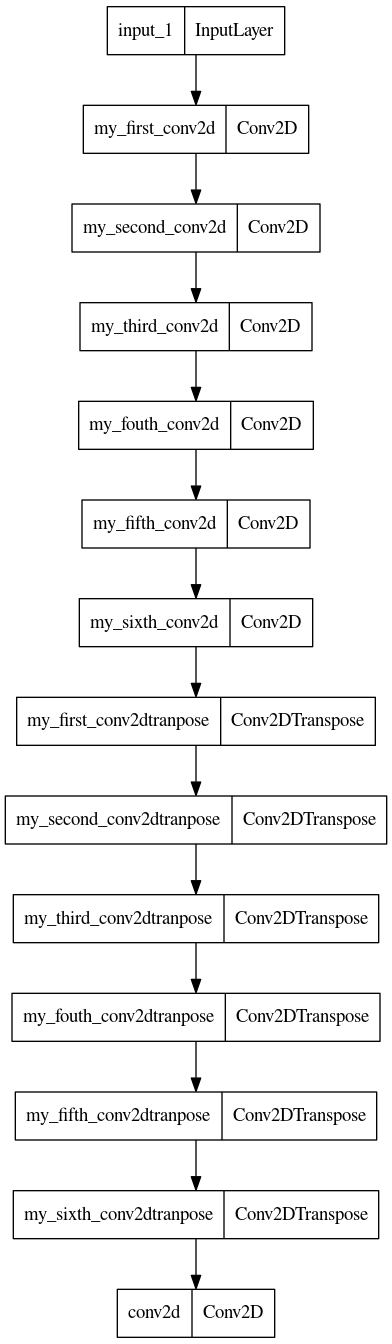

In [4]:
num_classes = 2
inputs = keras.Input(shape=img_size)
x = layers.Conv2D(64,3,strides=2,activation="relu",padding="same",name="my_first_conv2d")(inputs)
x = layers.Conv2D(64,3,activation="relu",padding="same",name="my_second_conv2d")(x)
x = layers.Conv2D(128,3,strides=2,activation="relu",padding="same",name="my_third_conv2d")(x)
x = layers.Conv2D(128,3,activation="relu",padding="same",name="my_fouth_conv2d")(x)
x = layers.Conv2D(256,3,strides=2,activation="relu",padding="same",name="my_fifth_conv2d")(x)
x = layers.Conv2D(256,3,activation="relu",padding="same",name="my_sixth_conv2d")(x)

x = layers.Conv2DTranspose(256,3,activation="relu",padding="same",name="my_first_conv2dtranpose")(x)
x = layers.Conv2DTranspose(256,3,strides=2,activation="relu",padding="same",name="my_second_conv2dtranpose")(x)
x = layers.Conv2DTranspose(128,3,activation="relu",padding="same",name="my_third_conv2dtranpose")(x)
x = layers.Conv2DTranspose(128,3,strides=2,activation="relu",padding="same",name="my_fouth_conv2dtranpose")(x)
x = layers.Conv2DTranspose(64,3,activation="relu",padding="same",name="my_fifth_conv2dtranpose")(x)
x = layers.Conv2DTranspose(64,3,strides=2,activation="relu",padding="same",name="my_sixth_conv2dtranpose")(x)

outputs = layers.Conv2D(num_classes,3,activation="softmax", padding="same")(x)
model = keras.Model(inputs,outputs)
model.summary()
keras.utils.plot_model(model)

In [6]:
model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy")
callbacks=[keras.callbacks.ModelCheckpoint("tcg_segment_model.keras",save_best_only=True)]
history = model.fit(train_input_imgs,train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs,val_targets))

Epoch 1/100


2023-08-07 13:24:18.432706: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.57MiB (rounded to 25758720)requested by op model/my_first_conv2d/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-07 13:24:18.468744: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-08-07 13:24:18.468770: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 59, Chunks in use: 59. 14.8KiB allocated for chunks. 14.8KiB in use in bin. 4.2KiB client-requested in use in bin.
2023-08-07 13:24:18.468778: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 16, Chunks in use: 16. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 8.0KiB client-requested in use in bin.
2023-08-07 13

ResourceExhaustedError: Graph execution error:

Detected at node 'model/my_first_conv2d/Conv2D' defined at (most recent call last):
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_40317/1497557127.py", line 3, in <cell line: 3>
      history = model.fit(train_input_imgs,train_targets,
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/N/soft/rhel7/deeplearning/Python-3.10.5/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/my_first_conv2d/Conv2D'
OOM when allocating tensor with shape[64,12,65,129] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/my_first_conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4009]

In [ ]:
import matplotlib.pyplot as plt
#print(history.__dict__)
epoch = history.epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
loss = history.history["loss"]
plt.figure()
plt.plot(epoch,loss,'r',label="loss")
plt.plot(epoch,val_loss,'g',label="val_loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("tcg_segment_model.keras")
test_image = val_input_imgs[8]
mask_2d = val_targets[8][:,:,0]
#
# display the first channel of the 12-channel sample input data
#
test_2d = test_image[:,:,0]
print(mask_2d.shape)
print(test_2d.shape,test_image.shape)
plt.figure()
#plt.axis("off")
#plt.matshow(test_2d)
#plt.imshow(test_2d)
#plt.imshow(mask_2d)
plt.contourf(mask_2d)
plt.colorbar()
#
# display the probability forecast of each channel
#
prediction_batch = model.predict(np.expand_dims(test_image,axis=0))
prediction = prediction_batch[0]
print(prediction_batch.shape,prediction.shape,prediction[0,0,0],prediction[0,0,1])
plt.figure()
plt.contourf(prediction[:,:,0])
plt.colorbar()
plt.figure()
plt.contourf(prediction[:,:,1])
plt.colorbar()
plt.show()
#
# display the index of the channel that has the maximum probability
#
def display_prediction(pred):
    mask = np.argmax(pred,axis=-1) # extract the index of the maximum of the softmax prediction, i.e. 0, 1, or 2
    #mask *= 127                   # rescale from 0-2 back to 0-255 range
    #print(mask.shape)
    #plt.axis("off")
    plt.contourf(mask)               # imshow can display a [0-255] array directly
    plt.colorbar()
display_prediction(prediction)  